<a href="https://colab.research.google.com/github/panagiotakf/Predicting-Fuel-Consumption-in-Shipping-by-Using-ML/blob/main/LSTM_for_cape1_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import pandas as pd # for easy dataset import
import sklearn # for simple ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # for data scaling in [0,1]
import pickle # for saving sklearn models
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score,f1_score
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

In [ ]:
WHICH_SHIP = 1 # ship to run

In [ ]:
# 1. Importing the dataset. Now we have as data, MEP too.
dataset = pd.read_csv('cape' +str(WHICH_SHIP) + '.csv')
X = dataset.iloc[:, [0, 1, 4, 5, 8,9]].values # keep only SOG, STW, DWS, WD Trim and MEP,bring all the rows but keep only the defined columns
X=X.reshape(-1,6) #do we need to reshape X too???

In [ ]:
#2. create dataframe with our data
X = pd.DataFrame(X, columns = ['SOG','STW','DWS','WD','TRIM','MEP']) #first transform np arrays to dataframes

In [ ]:
print(X)

            SOG       STW       DWS          WD      TRIM          MEP
0      0.001800  0.000615  0.006667    0.033753 -0.001921     4.481497
1      0.119200  0.010449  0.130000    1.425998 -0.032125   132.556280
2      0.470800  0.028888  0.596667   16.894491 -0.093411   521.574052
3      1.273133  0.047327  1.296667   45.102739 -0.188238  1293.921082
4      2.445533  0.065766  1.996667   73.287784 -0.313893  2305.202957
...         ...       ...       ...         ...       ...          ...
21270  6.362133  6.084035  3.923333  223.276873  9.030668  2839.817034
21271  5.834600  5.559586  4.010000  223.112688  9.041843  2634.610896
21272  5.304083  5.055309  4.166667  223.346691  9.057451  2506.412046
21273  4.981833  4.777590  4.366667  223.453380  9.021970  2351.075778
21274  4.717233  4.613174  4.566667  223.143018  8.513549  2278.539342

[21275 rows x 6 columns]


In [ ]:
#Τώρα θα πρέπει αρχικά να κάνουμε standardize τα δεδομένα μας
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X)
X_train=pd.DataFrame(X_train, columns = ['SOG','STW','DWS','WD','TRIM','MEP'])
print(X_train)


            SOG       STW       DWS        WD      TRIM       MEP
0      0.000000  0.000000  0.000000  0.000000  0.531814  0.000000
1      0.007542  0.000703  0.012342  0.003887  0.530743  0.009428
2      0.030128  0.002022  0.059039  0.047076  0.528569  0.038064
3      0.081669  0.003341  0.129086  0.125836  0.525205  0.094917
4      0.156983  0.004660  0.199133  0.204530  0.520748  0.169359
...         ...       ...       ...       ...       ...       ...
21270  0.408581  0.435088  0.391928  0.623310  0.852196  0.208713
21271  0.374693  0.397579  0.400600  0.622852  0.852593  0.193608
21272  0.340613  0.361513  0.416278  0.623505  0.853146  0.184171
21273  0.319912  0.341650  0.436291  0.623803  0.851888  0.172736
21274  0.302915  0.329891  0.456304  0.622937  0.833854  0.167397

[21275 rows x 6 columns]


In [ ]:
#Πρέπει να δημιουργήσουμε το κατάλληλο format για τα δεδομένα μας ώστε να εισαχθούν στο LSTM.
# Αυτό που θέλουμε είναι για τις W (εδώ 3) προηγούμενες χρονικές στιγμές να δημιοργήσουμε στήλες για τα χαρακτηριστικά μας.
#Οπότε η πρόβλεψη θα γίνεται με SOG(t-2),SOG(t-1),SOG(t),STW(t-2),...,MEP(t-2),MEP(t-1) και προβλέπουμε το MEP(t)
#17 στήλες για input και 1 για output
def series_to_supervised(data, n_in=1, n_out=1,dropnan=True):

    """
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """

    n_vars = 1 if len(data.columns)==1 else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' %(data.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % data.columns[j]) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (dat.columns[j], i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
W=3
data=series_to_supervised(X_train,W,1)
print(data)
#print(X_train['MEP'])
y=series_to_supervised((data[['MEP(t)']].copy()),1,1)
y=y.rename(columns={'MEP(t)(t)':'MEP(t+1)'})
print(y)


       SOG(t-3)  STW(t-3)  DWS(t-3)   WD(t-3)  TRIM(t-3)  MEP(t-3)  SOG(t-2)  \
3      0.000000  0.000000  0.000000  0.000000   0.531814  0.000000  0.007542   
4      0.007542  0.000703  0.012342  0.003887   0.530743  0.009428  0.030128   
5      0.030128  0.002022  0.059039  0.047076   0.528569  0.038064  0.081669   
6      0.081669  0.003341  0.129086  0.125836   0.525205  0.094917  0.156983   
7      0.156983  0.004660  0.199133  0.204530   0.520748  0.169359  0.229633   
...         ...       ...       ...       ...        ...       ...       ...   
21270  0.385813  0.411397  0.358906  0.628022   0.852718  0.205013  0.393741   
21271  0.393741  0.418586  0.373916  0.624442   0.852788  0.215051  0.414539   
21272  0.414539  0.442017  0.383923  0.624181   0.852309  0.217128  0.408581   
21273  0.408581  0.435088  0.391928  0.623310   0.852196  0.208713  0.374693   
21274  0.374693  0.397579  0.400600  0.622852   0.852593  0.193608  0.340613   

       STW(t-2)  DWS(t-2)   WD(t-2)  ..

In [ ]:
#όπως είπαμε θα χρησιμοπιήσουμε τις 23 πρώτες στήλες για input και την 24 για output.
N=(W+1)*6-1
trainX=data #data.iloc[: , :N]
trainY=y.iloc[:,1] #data.iloc[:,N]
print(trainX)
print(trainY)
print(trainX.shape)
print(trainY.shape)

       SOG(t-3)  STW(t-3)  DWS(t-3)   WD(t-3)  TRIM(t-3)  MEP(t-3)  SOG(t-2)  \
3      0.000000  0.000000  0.000000  0.000000   0.531814  0.000000  0.007542   
4      0.007542  0.000703  0.012342  0.003887   0.530743  0.009428  0.030128   
5      0.030128  0.002022  0.059039  0.047076   0.528569  0.038064  0.081669   
6      0.081669  0.003341  0.129086  0.125836   0.525205  0.094917  0.156983   
7      0.156983  0.004660  0.199133  0.204530   0.520748  0.169359  0.229633   
...         ...       ...       ...       ...        ...       ...       ...   
21270  0.385813  0.411397  0.358906  0.628022   0.852718  0.205013  0.393741   
21271  0.393741  0.418586  0.373916  0.624442   0.852788  0.215051  0.414539   
21272  0.414539  0.442017  0.383923  0.624181   0.852309  0.217128  0.408581   
21273  0.408581  0.435088  0.391928  0.623310   0.852196  0.208713  0.374693   
21274  0.374693  0.397579  0.400600  0.622852   0.852593  0.193608  0.340613   

       STW(t-2)  DWS(t-2)   WD(t-2)  ..

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
trainX.drop(trainX.tail(1).index,inplace=True) #νομίχω ότι πρέπει να πετάξουμε την τελευταία γραμμή τώρα που εξετάζουμε το t+1
trainX=trainX.values
print(trainX)
trainX=trainX.reshape(trainX.shape[0],W+1,6)
print(trainX.shape)
#τώρα τα δεδομένα μας έχουν το σωστό σχήμα για να μπουν μέσα στο keras lstm

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25835776e-01
  5.25205388e-01 9.49174869e-02]
 [7.54165899e-03 7.03339269e-04 1.23415610e-02 ... 2.04530402e-01
  5.20748457e-01 1.69359388e-01]
 [3.01280926e-02 2.02210031e-03 5.90393596e-02 ... 2.83161046e-01
  5.16149961e-01 2.41156064e-01]
 ...
 [3.93741196e-01 4.18586429e-01 3.73915944e-01 ... 6.22852059e-01
  8.52592792e-01 1.93607576e-01]
 [4.14538571e-01 4.42016738e-01 3.83922615e-01 ... 6.23505412e-01
  8.53146390e-01 1.84170676e-01]
 [4.08581474e-01 4.35087501e-01 3.91927952e-01 ... 6.23803294e-01
  8.51887904e-01 1.72736152e-01]]
(21271, 4, 6)


In [ ]:
#πάμε να φτιάξουμε την δομή του lSTM
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16)

Epoch 1/5
1330/1330 [==============================] - 14s 11ms/step - loss: 2.8704e-04
Epoch 2/5
1330/1330 [==============================] - 10s 8ms/step - loss: 2.8049e-04
Epoch 3/5
1330/1330 [==============================] - 11s 8ms/step - loss: 2.8709e-04
Epoch 4/5
1330/1330 [==============================] - 11s 8ms/step - loss: 2.8286e-04
Epoch 5/5
1330/1330 [==============================] - 12s 9ms/step - loss: 2.7759e-04


In [24]:
prediction = model.predict(trainX[-96:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction,X.shape[1], axis=-1)
#print(prediction_copies)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
print(y_pred_future)
print(X['MEP'].iloc[-96:])

3/3 [==============================] - 0s 5ms/step
[3387.5837 3392.5012 3397.381  3396.5854 3396.7397 3398.1826 3401.9185
 3405.8787 3403.64   3405.2698 3409.517  3404.1726 3399.683  3400.3013
 3400.5452 3399.728  3397.0386 3395.6328 3399.441  3399.0864 3397.8933
 3401.146  3405.533  3407.5298 3406.8196 3410.082  3413.555  3415.331
 3416.335  3417.7852 3419.4375 3420.3267 3425.3606 3428.852  3426.4014
 3425.3464 3426.8586 3427.4927 3428.0815 3429.799  3400.2673 3346.045
 3300.4358 3262.0515 3227.4858 3188.2112 3146.5142 3105.289  3065.5964
 3026.3396 3014.968  3030.4336 3033.7446 3030.0056 3030.5664 3035.2146
 3040.3154 3041.917  3045.6814 2965.2544 3034.7073 3163.939  3170.2224
 3215.4287 3256.0322 3299.2122 3336.4636 3380.3623 3418.9702 3383.8435
 3086.3933 2861.4094 2739.1902 2492.1565 2392.009  2478.3696 2543.9458
 2534.8008 2545.5596 2583.324  2630.0679 2761.6008 3014.9324 3260.3635
 3365.1729 3279.4124 2997.419  2700.64   2631.3015 2914.208  3053.0588
 2935.7756 2722.0364 2475.69

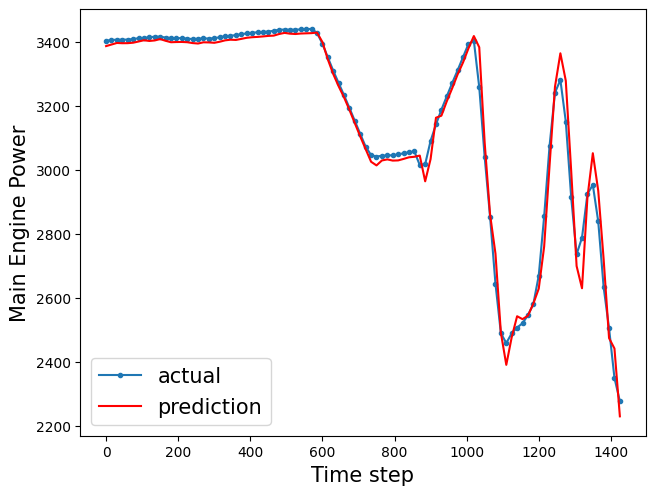

In [25]:
#τυπώνουμε ανα 15 λεπτά
l=[i for i in range(0,96*15,15)]
plt.plot(l, X['MEP'].iloc[-96:], marker='.', label="actual")
plt.plot(l, y_pred_future, 'r', label="prediction")
plt.tight_layout()
plt.ylabel('Main Engine Power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
